# HexGrids

1. https://www.freecodecamp.org/news/creating-grid-map-for-thailand-397b53a4ecf/
2. https://blog.tafkas.net/2018/09/28/creating-a-grid-based-on-geohashes/
3. https://blog.locale.ai/spatial-modelling-tidbits-honeycomb-or-fishnets/

H3
1. https://h3geo.org/#/
2. https://github.com/uber/h3-py
3. https://github.com/uber/h3-py-notebooks

GeoPandas Point in Polygon
1. https://gis.stackexchange.com/questions/208546/check-if-a-point-falls-within-a-multipolygon-with-python/208574

## H3 Core

From H3 [website](https://h3geo.org/#/documentation/overview/introduction)

> The H3 geospatial indexing system is a multi-precision hexagonal tiling of the sphere indexed with hierarchical linear indexes. The H3 Core Library provides functions for converting between latitude/longitude coordinates and H3 geospatial indexes. Specifically, the major library entry point functions (defined in h3api.h) provide the functionality:
>  
> 1. given a latitude/longitude point, find the index of the containing H3 cell at a particular resolution
> 2. given an H3 index, find the latitude/longitude cell center
> 3. given an H3 index, determine the cell boundary in latitude/longitude coordinates
and more.
>   
> The H3 Core Library is written entirely in C. Bindings for other languages are available.

We will use the [`h3-py`](https://github.com/uber/h3-py) Python API for H3 for this notebook.

## Steps

### HexGrid Binning
1. Obtain bounding polygon
2. Draw hexgrid within bounding polygon
3. Save hexgrid as SHP file
4. Save SHP as GeoPandas DF, one hexagon per record
5. Using Geopandas, identify points in polygon
6. Compute hexagon centroid
7. Compute hexagon point density

### HexGrid Geomasking
1. Identify hexagon neighbors
2. Randomly displace origin points to neighboring hexagon
3. Evaluate preservation of hexagon point density
4. Evaluate reidentification risk

In [1]:
%%writefile geoprivacy/hexgrid.py
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)   
from h3 import h3
import folium
import json

def assemble_polylines(hexagons):
    polylines = []
    lat = []
    lng = []
    for hex_ in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex_], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        # append versus extend (url reference below):
        #     https://stackoverflow.com/questions/252703/
        #        what-is-the-difference-between-pythons-list-methods-append-and-extend
        lat.extend(map(lambda v:v[0],polyline)) # gets all lats
        lng.extend(map(lambda v:v[1],polyline)) # gets all lons
        polylines.append(polyline) # gets all hexagons

    return polylines    
    
def visualize_hexagons(hexagons, color="red", folium_map=None, zoom_start=13):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex_ in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex_], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        # append versus extend (url reference below):
        #     https://stackoverflow.com/questions/252703/
        #        what-is-the-difference-between-pythons-list-methods-append-and-extend
        lat.extend(map(lambda v:v[0],polyline)) # gets all lats
        lng.extend(map(lambda v:v[1],polyline)) # gets all lons
        polylines.append(polyline) # gets all hexagons
    
    if folium_map is None:
        # default map
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=zoom_start, tiles='cartodbpositron')
    else:
        # custom map
        m = folium_map
    # iterate through hexagons, add each to map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,\
                                    weight=1,opacity=0.8, color=color)
        m.add_child(my_PolyLine)
    return m
    
def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

def get_h3_neighbors(h3_address, layers=1):
    neighbors = h3.k_ring_distances(h3_address, layers)
    return neighbors

def get_h3_address(latlon, resolution):
    lat, lon = latlon
    h3_address = h3.geo_to_h3(lat, lon, resolution)
    return h3_address

def read_json(file):
    with open(file) as f:
      json_file = json.load(f)
    return json_file

Overwriting geoprivacy/hexgrid.py


In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)   
#from h3 import h3
import h3.api.basic_int as h3
import folium
from geoprivacy.hexgrid import visualize_hexagons, visualize_polygon, get_h3_address, get_h3_neighbors, \
    assemble_polylines

SOHO_ADDRESS = (51.513578, -0.136722)
resolution = 12
h3_address = get_h3_address(SOHO_ADDRESS, resolution) 

h3_address

'8c195da498f03ff'

In [3]:
polylines = assemble_polylines([h3_address])

polylines

[[(51.51369658646529, -0.13674199293377431),
  (51.513672216773905, -0.13687891565469323),
  (51.51358089950771, -0.1369038857184954),
  (51.51351395204412, -0.1367919333872329),
  (51.51353832175247, -0.13665501111075515),
  (51.51362963890744, -0.13663004072111468),
  (51.51369658646529, -0.13674199293377431)]]

In [4]:
from shapely import geometry

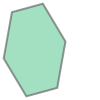

In [5]:
polygon = geometry.Polygon(polylines[0])

polygon

In [6]:
x = get_h3_neighbors(h3_address, resolution)

x

[{'8c195da498f03ff'},
 {'8c195da498f01ff',
  '8c195da498f07ff',
  '8c195da498f0bff',
  '8c195da498f15ff',
  '8c195da498f1dff',
  '8c195da498f39ff'},
 {'8c195da498f05ff',
  '8c195da498f09ff',
  '8c195da498f0dff',
  '8c195da498f11ff',
  '8c195da498f17ff',
  '8c195da498f19ff',
  '8c195da498f2bff',
  '8c195da498f31ff',
  '8c195da498f3bff',
  '8c195da498f3dff',
  '8c195da498f55ff',
  '8c195da498f57ff'},
 {'8c195da498c69ff',
  '8c195da498c6dff',
  '8c195da498e25ff',
  '8c195da498f13ff',
  '8c195da498f1bff',
  '8c195da498f21ff',
  '8c195da498f23ff',
  '8c195da498f29ff',
  '8c195da498f33ff',
  '8c195da498f35ff',
  '8c195da498f37ff',
  '8c195da498f43ff',
  '8c195da498f47ff',
  '8c195da498f51ff',
  '8c195da498f53ff',
  '8c195da498f5dff',
  '8c195da498f63ff',
  '8c195da498f6bff'},
 {'8c195da4981b7ff',
  '8c195da498c45ff',
  '8c195da498c4dff',
  '8c195da498c61ff',
  '8c195da498c65ff',
  '8c195da498c6bff',
  '8c195da498d49ff',
  '8c195da498d4bff',
  '8c195da498d59ff',
  '8c195da498d5dff',
  '8c195d

In [7]:
polygon = h3.h3_set_to_multi_polygon([h3_address], geo_json=False)
polygon

[[[(51.51369658646529, -0.13674199293377431),
   (51.513672216773905, -0.13687891565469323),
   (51.51358089950771, -0.1369038857184954),
   (51.51351395204412, -0.1367919333872329),
   (51.51353832175247, -0.13665501111075515),
   (51.51362963890744, -0.13663004072111468)]]]

In [8]:
for loop in polygon:
    print(loop)

[[(51.51369658646529, -0.13674199293377431), (51.513672216773905, -0.13687891565469323), (51.51358089950771, -0.1369038857184954), (51.51351395204412, -0.1367919333872329), (51.51353832175247, -0.13665501111075515), (51.51362963890744, -0.13663004072111468)]]


In [9]:
m = visualize_hexagons([h3_address],zoom_start=18)

m

In [10]:
h3_address = h3.geo_to_h3(SOHO_ADDRESS[0], SOHO_ADDRESS[1], 12) # lat, lng, hex resolution 

h3_address

'8c195da498f03ff'

In [11]:
hex_center_coordinates = h3.h3_to_geo(h3_address) # array of [lat, lng] 

hex_center_coordinates

(51.51360526930423, -0.13676696319773518)

In [12]:
hex_boundary = h3.h3_to_geo_boundary(h3_address) # array of arrays of [lat, lng] 

hex_boundary

((51.51369658646529, -0.13674199293377431),
 (51.513672216773905, -0.13687891565469323),
 (51.51358089950771, -0.1369038857184954),
 (51.51351395204412, -0.1367919333872329),
 (51.51353832175247, -0.13665501111075515),
 (51.51362963890744, -0.13663004072111468))

In [13]:
h3.k_ring_distances(h3_address,10)

[{'8c195da498f03ff'},
 {'8c195da498f01ff',
  '8c195da498f07ff',
  '8c195da498f0bff',
  '8c195da498f15ff',
  '8c195da498f1dff',
  '8c195da498f39ff'},
 {'8c195da498f05ff',
  '8c195da498f09ff',
  '8c195da498f0dff',
  '8c195da498f11ff',
  '8c195da498f17ff',
  '8c195da498f19ff',
  '8c195da498f2bff',
  '8c195da498f31ff',
  '8c195da498f3bff',
  '8c195da498f3dff',
  '8c195da498f55ff',
  '8c195da498f57ff'},
 {'8c195da498c69ff',
  '8c195da498c6dff',
  '8c195da498e25ff',
  '8c195da498f13ff',
  '8c195da498f1bff',
  '8c195da498f21ff',
  '8c195da498f23ff',
  '8c195da498f29ff',
  '8c195da498f33ff',
  '8c195da498f35ff',
  '8c195da498f37ff',
  '8c195da498f43ff',
  '8c195da498f47ff',
  '8c195da498f51ff',
  '8c195da498f53ff',
  '8c195da498f5dff',
  '8c195da498f63ff',
  '8c195da498f6bff'},
 {'8c195da4981b7ff',
  '8c195da498c45ff',
  '8c195da498c4dff',
  '8c195da498c61ff',
  '8c195da498c65ff',
  '8c195da498c6bff',
  '8c195da498d49ff',
  '8c195da498d4bff',
  '8c195da498d59ff',
  '8c195da498d5dff',
  '8c195d

In [14]:
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 5)), color="black", zoom_start=18)

m

TypeError: Argument 'h' has incorrect type (expected str, got set)

In [ ]:
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 5)[5]), color="black", zoom_start=18)

m

In [15]:
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 5)[5]), color="black", zoom_start=18)

m

In [16]:
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 5)[4]), color="purple", folium_map=m, zoom_start=18)

m

In [17]:
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 5)[3]), color="blue", folium_map=m, zoom_start=18)

m

In [18]:
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 5)[2]), color="green", folium_map=m)

m

In [19]:
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 5)[1]), color = "red", folium_map=m)

m

In [20]:
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 5)[0]), color = "black", folium_map=m)

m

## Drawing HexGrid inside binding polygon (London ward SHP file)

In [21]:
import geopandas as gpd

epsg27700_gdf = gpd.read_file('resources/London-wards-2018-EPSG_27700.json')
westend_gdf = epsg27700_gdf[epsg27700_gdf['NAME']=='West End']
westend_gdf.to_file('resources/westend.json', driver='GeoJSON')

In [22]:
westend_gdf.crs

In [23]:
import json

with open('resources/westend.json') as f:
  westend_json = json.load(f)

In [24]:
westend_json

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'FID': 487,
    'NAME': 'West End',
    'GSS_CODE': 'E05000649',
    'DISTRICT': 'City of Westminster',
    'LAGSSCODE': 'E09000033',
    'HECTARES': 199.973,
    'NONLD_AREA': 0.0},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[528386.6992350583, 179725.6034160063],
      [528381.100838569, 179730.10212826583],
      [528356.8026434965, 179773.7996200006],
      [528331.1027880367, 179842.49995475734],
      [528350.0004680862, 179857.69560505165],
      [528315.6020731619, 179935.60330422805],
      [528313.4995825805, 179938.10258881637],
      [528311.9000407263, 179939.6021595691],
      [528325.4961464861, 179962.09572086117],
      [528340.601098428, 179976.50159722584],
      [528410.0987184704, 179966.30451610533],
      [528420.9986892493, 179991.09741921944],
      [528422.5982311034, 180000.00486949086],
      [528430.2991181741, 180042.4027332404],
      [528434.9988030032, 180091.

In [25]:
geoJson = {'type': 'Polygon',
 'coordinates': [[[37.813318999983238, -122.4089866999972145], [ 37.7866302000007224, -122.3805436999997056 ], [37.7198061999978478, -122.3544736999993603], [ 37.7076131999975672, -122.5123436999983966 ], [37.7835871999971715, -122.5247187000021967],  [37.8151571999998453, -122.4798767000009008]]] }

geoJson

{'type': 'Polygon',
 'coordinates': [[[37.81331899998324, -122.40898669999721],
   [37.78663020000072, -122.3805436999997],
   [37.71980619999785, -122.35447369999936],
   [37.70761319999757, -122.5123436999984],
   [37.78358719999717, -122.5247187000022],
   [37.815157199999845, -122.4798767000009]]]}

In [26]:
polyline = geoJson['coordinates'][0]
polyline

[[37.81331899998324, -122.40898669999721],
 [37.78663020000072, -122.3805436999997],
 [37.71980619999785, -122.35447369999936],
 [37.70761319999757, -122.5123436999984],
 [37.78358719999717, -122.5247187000022],
 [37.815157199999845, -122.4798767000009]]

In [43]:
import geopandas as gpd

gdf = gpd.read_file('resources/westend.json')

gdf

,FID,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry
0,487,West End,E05000649,City of Westminster,E09000033,199.973,0.0,"POLYGON ((528386.699 179725.603, 528381.101 17..."


<AxesSubplot:>

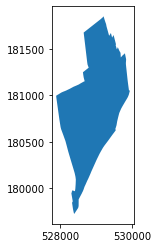

In [44]:
gdf.plot()

In [45]:
gdf['geometry'].to_file("resources/output.json", driver="GeoJSON")

In [46]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [47]:
gdf = gdf.to_crs('EPSG:4326')

In [48]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [49]:
gdf['geometry'].to_file("resources/output.json", driver="GeoJSON")

In [50]:
%run geoprivacy/hexgrid.py

westend_json = read_json('resources/output.json')['features'][0]['geometry']

westend_json

{'type': 'Polygon',
 'coordinates': [[[528386.6992350583, 179725.6034160063],
   [528381.100838569, 179730.10212826583],
   [528356.8026434965, 179773.7996200006],
   [528331.1027880367, 179842.49995475734],
   [528350.0004680862, 179857.69560505165],
   [528315.6020731619, 179935.60330422805],
   [528313.4995825805, 179938.10258881637],
   [528311.9000407263, 179939.6021595691],
   [528325.4961464861, 179962.09572086117],
   [528340.601098428, 179976.50159722584],
   [528410.0987184704, 179966.30451610533],
   [528420.9986892493, 179991.09741921944],
   [528422.5982311034, 180000.00486949086],
   [528430.2991181741, 180042.4027332404],
   [528434.9988030032, 180091.99853660434],
   [528425.5994333451, 180121.60006326524],
   [528403.8984325203, 180160.39895720914],
   [528377.4977468667, 180196.09873826487],
   [528303.0036197955, 180292.40117200935],
   [528226.4976978151, 180392.70246109465],
   [528175.6009356226, 180467.90093577775],
   [528147.699648848, 180508.19940047472],
   [

In [35]:
polyline = westend_json['coordinates'][0]
polyline

[[528386.6992350583, 179725.6034160063],
 [528381.100838569, 179730.10212826583],
 [528356.8026434965, 179773.7996200006],
 [528331.1027880367, 179842.49995475734],
 [528350.0004680862, 179857.69560505165],
 [528315.6020731619, 179935.60330422805],
 [528313.4995825805, 179938.10258881637],
 [528311.9000407263, 179939.6021595691],
 [528325.4961464861, 179962.09572086117],
 [528340.601098428, 179976.50159722584],
 [528410.0987184704, 179966.30451610533],
 [528420.9986892493, 179991.09741921944],
 [528422.5982311034, 180000.00486949086],
 [528430.2991181741, 180042.4027332404],
 [528434.9988030032, 180091.99853660434],
 [528425.5994333451, 180121.60006326524],
 [528403.8984325203, 180160.39895720914],
 [528377.4977468667, 180196.09873826487],
 [528303.0036197955, 180292.40117200935],
 [528226.4976978151, 180392.70246109465],
 [528175.6009356226, 180467.90093577775],
 [528147.699648848, 180508.19940047472],
 [528122.799564315, 180534.60184286226],
 [528090.1985927114, 180570.30162391852],


In [36]:
polyline.append(polyline[0])

polyline

[[528386.6992350583, 179725.6034160063],
 [528381.100838569, 179730.10212826583],
 [528356.8026434965, 179773.7996200006],
 [528331.1027880367, 179842.49995475734],
 [528350.0004680862, 179857.69560505165],
 [528315.6020731619, 179935.60330422805],
 [528313.4995825805, 179938.10258881637],
 [528311.9000407263, 179939.6021595691],
 [528325.4961464861, 179962.09572086117],
 [528340.601098428, 179976.50159722584],
 [528410.0987184704, 179966.30451610533],
 [528420.9986892493, 179991.09741921944],
 [528422.5982311034, 180000.00486949086],
 [528430.2991181741, 180042.4027332404],
 [528434.9988030032, 180091.99853660434],
 [528425.5994333451, 180121.60006326524],
 [528403.8984325203, 180160.39895720914],
 [528377.4977468667, 180196.09873826487],
 [528303.0036197955, 180292.40117200935],
 [528226.4976978151, 180392.70246109465],
 [528175.6009356226, 180467.90093577775],
 [528147.699648848, 180508.19940047472],
 [528122.799564315, 180534.60184286226],
 [528090.1985927114, 180570.30162391852],


In [37]:
for p in polyline:
    print(p)

[528386.6992350583, 179725.6034160063]
[528381.100838569, 179730.10212826583]
[528356.8026434965, 179773.7996200006]
[528331.1027880367, 179842.49995475734]
[528350.0004680862, 179857.69560505165]
[528315.6020731619, 179935.60330422805]
[528313.4995825805, 179938.10258881637]
[528311.9000407263, 179939.6021595691]
[528325.4961464861, 179962.09572086117]
[528340.601098428, 179976.50159722584]
[528410.0987184704, 179966.30451610533]
[528420.9986892493, 179991.09741921944]
[528422.5982311034, 180000.00486949086]
[528430.2991181741, 180042.4027332404]
[528434.9988030032, 180091.99853660434]
[528425.5994333451, 180121.60006326524]
[528403.8984325203, 180160.39895720914]
[528377.4977468667, 180196.09873826487]
[528303.0036197955, 180292.40117200935]
[528226.4976978151, 180392.70246109465]
[528175.6009356226, 180467.90093577775]
[528147.699648848, 180508.19940047472]
[528122.799564315, 180534.60184286226]
[528090.1985927114, 180570.30162391852]
[528029.696334333, 180634.00338949676]
[528014.0

In [38]:
lat = [p[1] for p in polyline]

lat

[179725.6034160063,
 179730.10212826583,
 179773.7996200006,
 179842.49995475734,
 179857.69560505165,
 179935.60330422805,
 179938.10258881637,
 179939.6021595691,
 179962.09572086117,
 179976.50159722584,
 179966.30451610533,
 179991.09741921944,
 180000.00486949086,
 180042.4027332404,
 180091.99853660434,
 180121.60006326524,
 180160.39895720914,
 180196.09873826487,
 180292.40117200935,
 180392.70246109465,
 180467.90093577775,
 180508.19940047472,
 180534.60184286226,
 180570.30162391852,
 180634.00338949676,
 180657.29672185658,
 180683.69916424446,
 180741.20270404522,
 180964.99864319206,
 180995.1999981518,
 181006.99662140675,
 181012.90493017307,
 181018.3033848831,
 181022.90206852404,
 181029.10029430315,
 181033.49903517793,
 181033.59900656075,
 181038.69754711987,
 181044.19597321277,
 181045.29565843253,
 181051.10399581533,
 181056.4024791419,
 181057.4021929751,
 181058.1019926605,
 181064.00030428736,
 181070.3984728324,
 181092.60211711214,
 181104.69865451625,
 1

In [39]:
lng = [p[0] for p in polyline]

lng

[528386.6992350583,
 528381.100838569,
 528356.8026434965,
 528331.1027880367,
 528350.0004680862,
 528315.6020731619,
 528313.4995825805,
 528311.9000407263,
 528325.4961464861,
 528340.601098428,
 528410.0987184704,
 528420.9986892493,
 528422.5982311034,
 528430.2991181741,
 528434.9988030032,
 528425.5994333451,
 528403.8984325203,
 528377.4977468667,
 528303.0036197955,
 528226.4976978151,
 528175.6009356226,
 528147.699648848,
 528122.799564315,
 528090.1985927114,
 528029.696334333,
 528014.096678725,
 528003.3038937403,
 527980.0033510616,
 527900.1994046398,
 527890.8000349817,
 527938.0030097998,
 527965.0962805862,
 527986.5004592112,
 528005.7032065216,
 528030.801172521,
 528054.7036046602,
 528055.2972490597,
 528084.6991369552,
 528121.7029711881,
 528129.0987909981,
 528165.698617237,
 528193.1958960176,
 528198.5964110405,
 528202.3973842092,
 528233.9017626861,
 528268.3001576103,
 528373.5978329646,
 528447.3004341697,
 528504.3974823124,
 528526.6014318643,
 528546.

In [40]:
sum(lat)/len(lat)

180795.15340006843

In [41]:
sum(lng)/len(lng)

528921.0019989498

In [42]:
m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color="green")
m.add_child(my_PolyLine)

hexagons = list(h3.polyfill(geoJson, 8))
polylines = []
lat = []
lng = []
for hex in hexagons:
    polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
    # flatten polygons into loops.
    outlines = [loop for polygon in polygons for loop in polygon]
    polyline = [outline + [outline[0]] for outline in outlines][0]
    lat.extend(map(lambda v:v[0],polyline))
    lng.extend(map(lambda v:v[1],polyline))
    polylines.append(polyline)
    
for polyline in polylines:
    my_PolyLine=folium.PolyLine(locations=polyline,weight=1,color='red')
    m.add_child(my_PolyLine)

m